In [27]:
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

2.12.0
2.12.0
Mounted at /content/drive


In [ ]:
# imports
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

In [30]:
# Download the data from:
# https://www.kaggle.com/datasets/flo2607/traffic-signs-classification?datasetId=545505&sortBy=voteCount
# extract it in the path
# !unzip 'drive/MyDrive/Colab_Notebooks_2/traffic_signs/data/myData.zip' -d 'drive/MyDrive/Colab_Notebooks_2/traffic_signs/data/'
path = 'drive/MyDrive/Colab_Notebooks_2/traffic_signs/data/myData'
lab = pd.read_csv('drive/MyDrive/Colab_Notebooks_2/traffic_signs/data/labels.csv')
lab.head()

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [31]:
datagen = ImageDataGenerator()
data = datagen.flow_from_directory(path,
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73139 images belonging to 43 classes.


In [32]:
X , y = data.next()

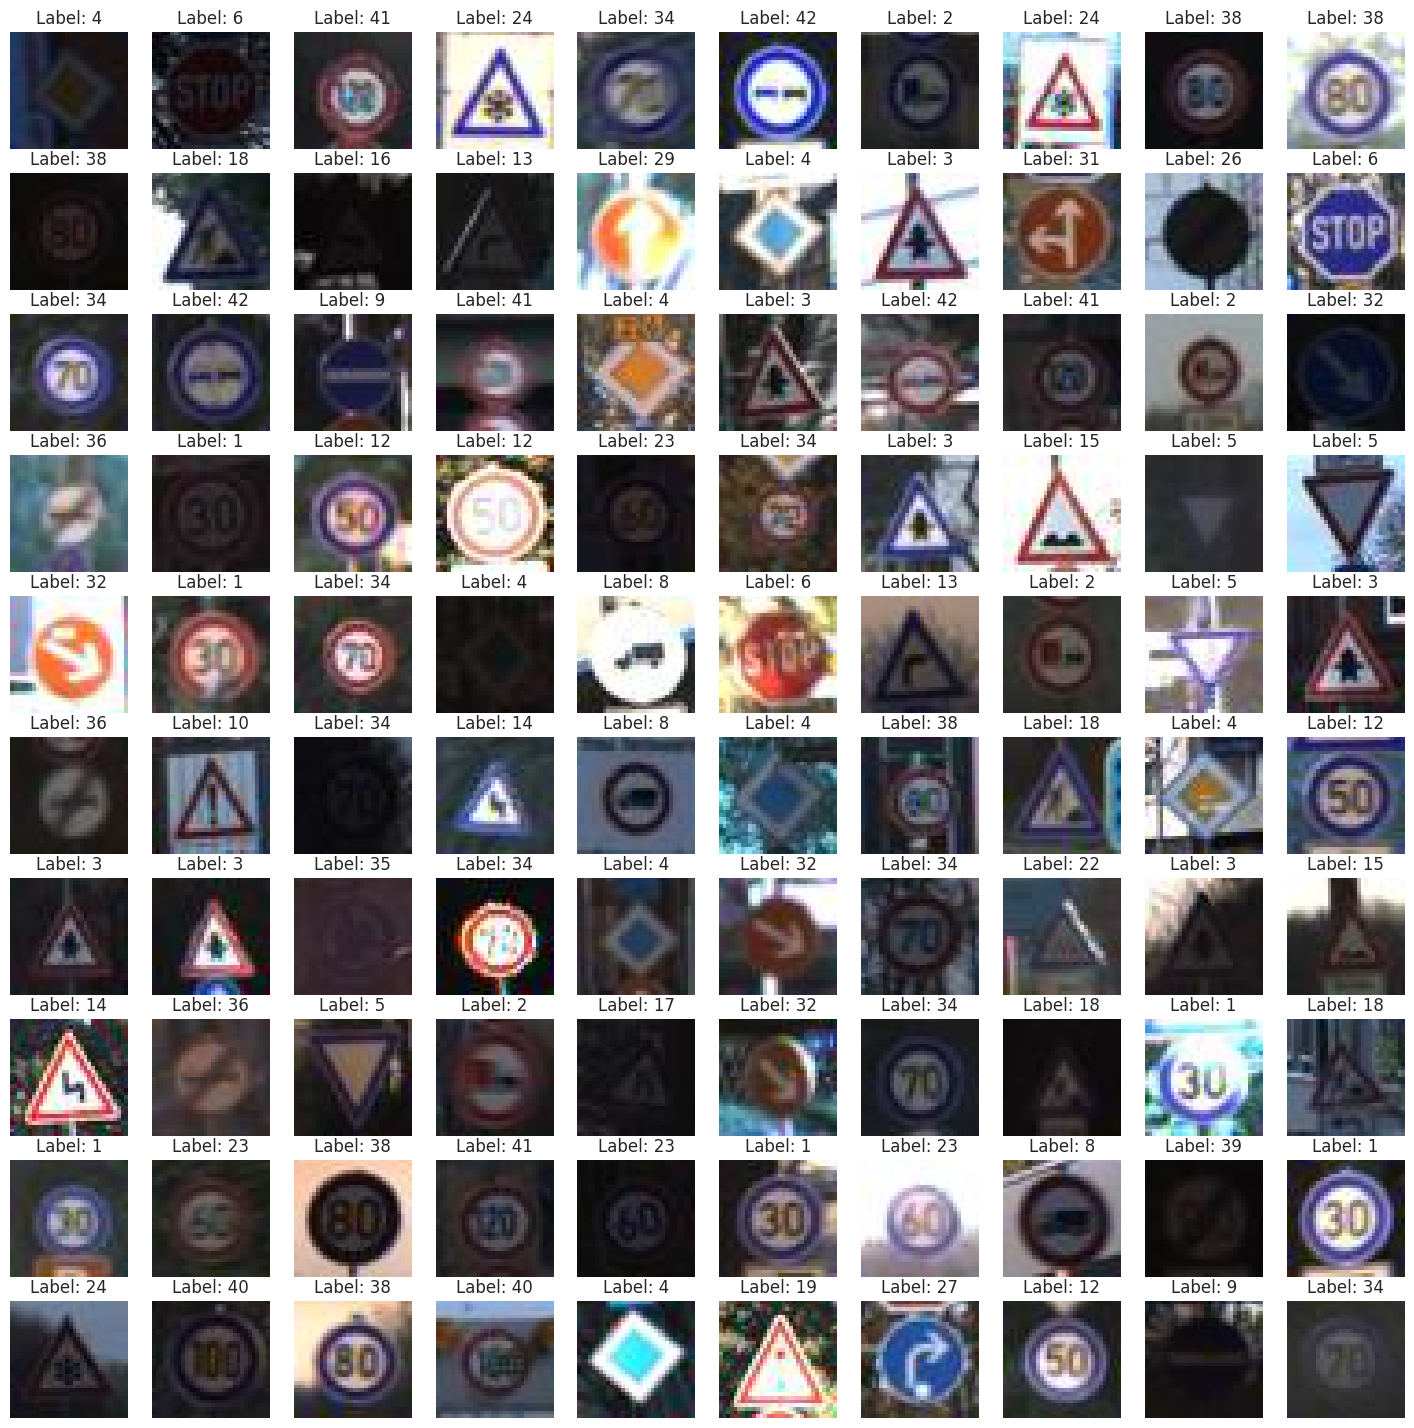

In [33]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))

In [36]:
# Labels are one hot encoded
print("Data Shape  :", X.shape)
print("Labels shape:", y.shape)

Data Shape  : (73139, 32, 32, 3)
Labels shape: (73139, 43)


In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
print("Train Shape: {}\nTest Shape : {}".format(x_train.shape, x_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


In [38]:
# determine the number of classes and input shape
in_shape = x_train.shape[1:]
n_classes = y_train.shape[1]
print(in_shape, n_classes, sep="\n")

(32, 32, 3)
43


In [39]:
# normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# define model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(Conv2D(10, (3,3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 10)        2890      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 128)               251008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [40]:
# compile the model and apply early stopping
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', restore_best_weights=True)

# fit the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1, validation_split=0.25, callbacks=[early])

Epoch 1/5
1372/1372 [==============================] - 67s 48ms/step - loss: 0.8520 - accuracy: 0.7597 - val_loss: 0.1675 - val_accuracy: 0.9555
Epoch 2/5
1372/1372 [==============================] - 68s 50ms/step - loss: 0.1938 - accuracy: 0.9418 - val_loss: 0.1098 - val_accuracy: 0.9681
Epoch 3/5
1372/1372 [==============================] - 65s 47ms/step - loss: 0.1157 - accuracy: 0.9629 - val_loss: 0.0986 - val_accuracy: 0.9732
Epoch 4/5
1372/1372 [==============================] - 65s 48ms/step - loss: 0.0847 - accuracy: 0.9730 - val_loss: 0.0603 - val_accuracy: 0.9843
Epoch 5/5
1372/1372 [==============================] - 65s 47ms/step - loss: 0.0672 - accuracy: 0.9789 - val_loss: 0.0517 - val_accuracy: 0.9865


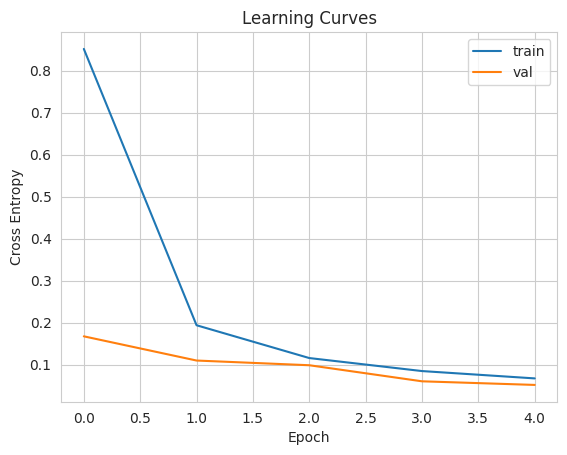

In [41]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [42]:
class_labels = dict()
for dirs in os.listdir(path):
    count = len(os.listdir(path+'/'+dirs))
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]
nb_classes = len(class_labels.keys())

pred = np.argmax(model.predict(x_test), axis = 1)
labels = [class_labels[i] for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

458/458 [==============================] - 5s 10ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.99      0.97      0.98       102
                              Speed limit (30km/h)       0.98      0.99      0.98       954
                              Speed limit (50km/h)       1.00      0.99      1.00       761
                              Speed limit (60km/h)       0.96      0.99      0.98       499
                              Speed limit (70km/h)       1.00      1.00      1.00       818
                              Speed limit (80km/h)       1.00      1.00      1.00       801
                       End of speed limit (80km/h)       0.99      1.00      0.99       290
                             Speed limit (100km/h)       0.98      0.99      0.98       245
                             Speed limit (120km/h)       1.00      1.00      1.00       168
                       

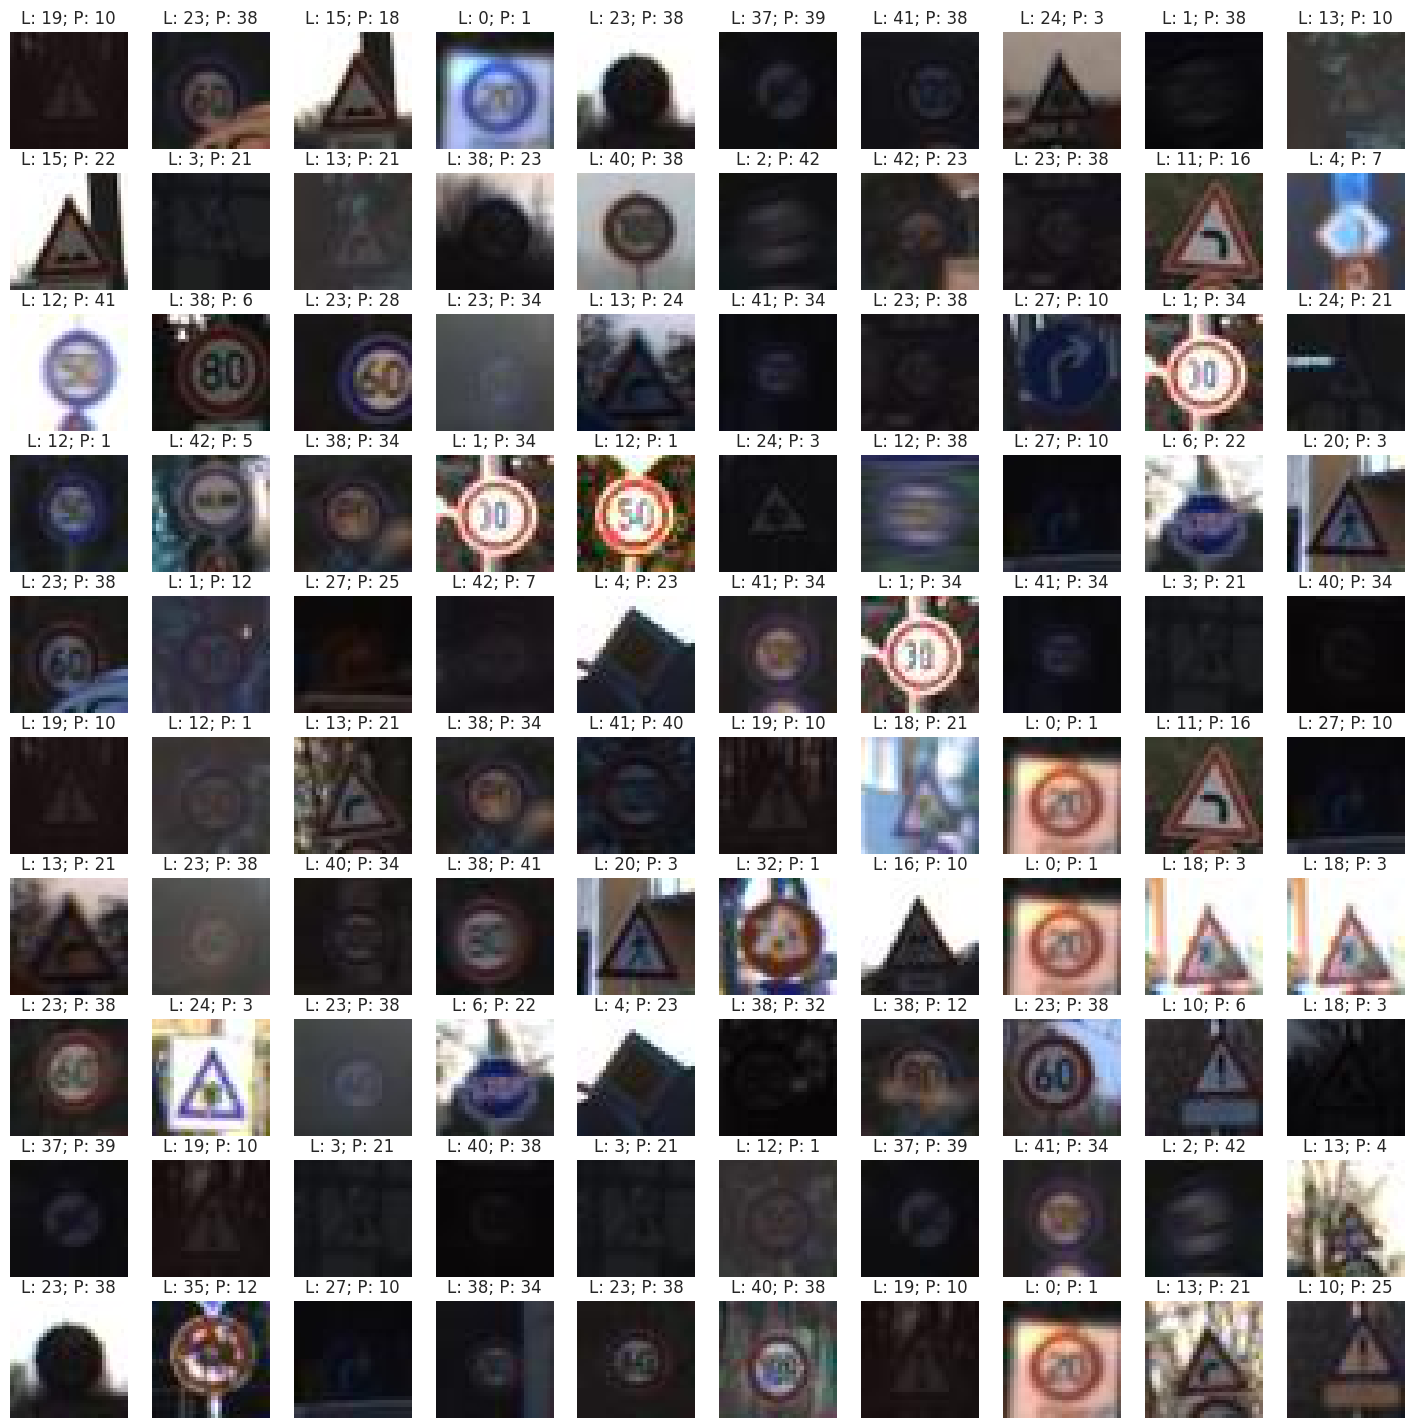

In [43]:
x_test_miss = x_test[np.argmax(y_test, axis = 1)!=pred]*255
pred_miss = pred[np.argmax(y_test, axis = 1)!=pred]
true_miss = np.argmax(y_test, axis = 1)[np.argmax(y_test, axis = 1)!=pred]

fig, axes = plt.subplots(10,10, figsize=(18,18))

for i,ax in enumerate(axes.flat):
    r = np.random.randint(x_test_miss.shape[0])
    ax.imshow(x_test_miss[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('L: '+str(true_miss[r]) + '; P: '+str(pred_miss[r]))